In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from scipy.ndimage import gaussian_filter, laplace, convolve, maximum_filter
from PIL import Image
from skimage.feature import peak_local_max
import hyperspy.api as hs
import atomap.api as am
import atomap.dummy_data as dummy_data
from ncempy.io import dm
import os

In [2]:
def SVD(img, k = 10):
    # 对图像矩阵进行SVD分解
    U, singular_values, Vt = np.linalg.svd(img)

    # 设置保留的奇异值数量
    # k = 10  # 这个数字需要根据实际情况调整

    # 构建截断后的Sigma矩阵
    sigma_truncated = singular_values[:k]
    sigma_matrix = np.diag(sigma_truncated)

    # 重建图像
    denoised_image_svd = U[:, :k] @ sigma_matrix @ Vt[:k, :]

    # 将数据转换回uint8以匹配原始图像的类型
    if img.dtype == 'float32' or img.dtype == 'float64':
        denoised_image_svd = (denoised_image_svd * img.ptp()).astype(img.dtype)
    else:
        denoised_image_svd = denoised_image_svd.astype(img.dtype)

    return denoised_image_svd

def blob_detection(img, threshold=150.0, min_distance=10):
    """Detect blobs in the scale-space using a maximum filter."""
    detected_blobs = []
    local_max = maximum_filter(img, min_distance) == img
    blobs = np.argwhere(local_max & (img > threshold))
    for blob in blobs:
        if not any(np.linalg.norm(np.array(blob) - np.array(detected_blob)) < min_distance 
                   for detected_blob in detected_blobs):
            detected_blobs.append((blob[0], blob[1]))
    return detected_blobs

def visualize_results(image, blobs, title, save_path=None) -> Figure:
    """Visualize the original image with detected blobs and return the figure object."""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    for y, x in blobs:
        ax.plot(x, y, 'r+', markersize=2)
    ax.set_title(title)
    ax.axis('off')
    
    if save_path:
        fig.savefig(save_path)
    
    return fig

def gaus_refine(image, input_blobs, plt_title, save_path=None):
    signal_2d = hs.signals.Signal2D(image)
    # signal_2d.plot()
    # s_peaks = am.get_feature_separation(signal_2d, separation_range=(7, 250), show_progressbar=False)
    # s_peaks.plot()
    # print(s_peaks)

    # atom_positions = am.get_atom_positions(signal_2d, separation=10)


    nested_detected_blobs = [[y,x] for x,y in input_blobs]

    # print('atom_positions[0]:', atom_positions[0])
    # print(type(nested_detected_blobs))
    # print('nested_detected_blobs[0]:', nested_detected_blobs[0])

    sublattice = am.Sublattice(nested_detected_blobs, image=signal_2d.data)

    sublattice.find_nearest_neighbors()
    sublattice.refine_atom_positions_using_center_of_mass(show_progressbar=False)
    sublattice.refine_atom_positions_using_2d_gaussian(show_progressbar=False)
    # sublattice.get_position_history().plot()

    atom_list = sublattice.atom_list
    # print(type(atom_list))

    # print(atom_list[0])
    print(type(atom_list[0]))
    blobs = []

    for pos in atom_list:
        x, y = pos.get_pixel_position()
        blobs.append([y,x])
    
    # save_path = os.path.dirname(image_path) + '/' + 'gaussian_refine.png'
    visualize_results(image, blobs, plt_title, save_path)
    print("blobs_count:", len(blobs))
    return blobs

def read_dm(file_name):
    im = dm.dmReader(file_name)
    data = im['data']
    pixelSize = im['pixelSize']
    return data, pixelSize

def normalizeAndConvert2uint8(image):
    return (((image - image.min())/image.ptp()) * np.iinfo(np.uint8).max).astype(np.uint8) if image.ptp() != 0 else image.astype(np.uint8)

def seperate_into_row(sorted_blob, threshold = 15):
    group = []
    row_count = 0
    i = 0

    # 外层循环
    while i < len(sorted_blob):
        row = [sorted_blob[i]]
        row_count = 1

        # 内层循环检查相邻元素的差值
        for j in range(i + 1, len(sorted_blob)):
            # 如果两个元素的第一个值的差值小于 10，则加入同一组
            if abs(sorted_blob[j][0] - sorted_blob[i][0]) < threshold:
                row.append(sorted_blob[j])
                row_count += 1
            else:
                break  # 如果差值超过 10，结束当前分组

        # 将当前分组加入总列表
        group.append(row)

        # 更新外层循环计数器 i
        i += row_count

    # 输出最终分组
    group_count = len(group)
    print(f"Total groups: {group_count}")
    # for g in group:
    #     print(len(g))
    #     # print(g)
    #     pass
    return group

def sort_blobs_by_y(blobs):
    sort_b = sorted(blobs, key=lambda x: x[0])
    # print(sort_b[0:80])
    return sort_b

def sort_blobs_by_x(blobs):
    sort_b = sorted(blobs, key=lambda x: x[1])
    return sort_b

In [3]:
dm_dir = '/internfs/yuliang/torch/identify/dataset/VOCl_distance'
png_dir = '/internfs/yuliang/torch/identify/dataset/VOCl_distance_png'
os.makedirs(png_dir, exist_ok=True)

dm_files = os.listdir(dm_dir)
for dm_file in dm_files:
    image,ps = read_dm(os.path.join(dm_dir,dm_file))
    image = normalizeAndConvert2uint8(image)
    savename = os.path.join(png_dir, os.path.splitext(dm_file)[0]+'.png')
    Image.fromarray(image).save(savename)

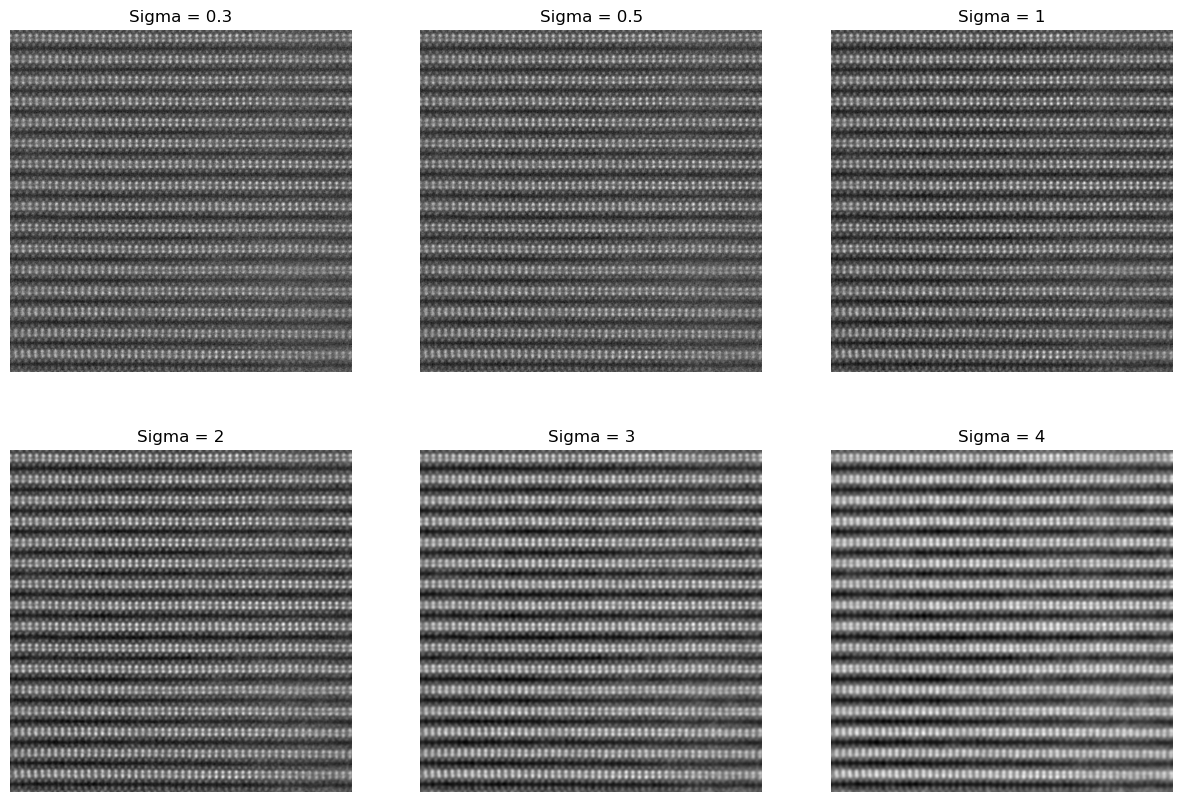

In [3]:
image_path = '/internfs/yuliang/torch/identify/dataset/VOCl_distance_png/110/VOCl-110.png'
img = Image.open(image_path).convert('L')
img = np.array(img)
PIXEL_SIZE = 0.013

# 尝试不同的 sigma 值
sigmas = [0.3, 0.5, 1, 2, 3, 4]
filtered_images = [gaussian_filter(img, sigma=s) for s in sigmas]

# 显示结果
plt.figure(figsize=(15, 10))
for i, sigma in enumerate(sigmas):
    plt.subplot(2, 3, i+1)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(f'Sigma = {sigma}')
    plt.axis('off')
plt.show()

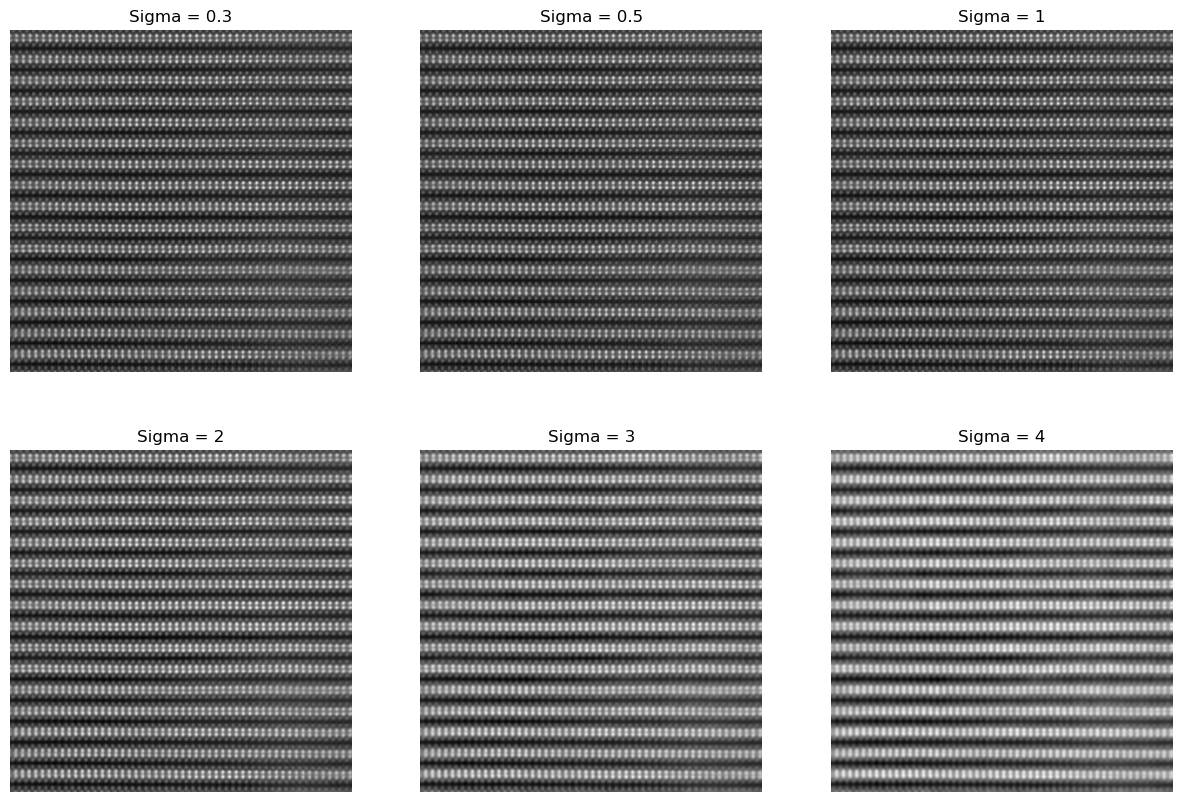

In [4]:
gaus_filt_svd_img = [SVD(img) for img in filtered_images]
# 显示结果
plt.figure(figsize=(15, 10))
for i, sigma in enumerate(sigmas):
    plt.subplot(2, 3, i+1)
    plt.imshow(gaus_filt_svd_img[i], cmap='gray')
    plt.title(f'Sigma = {sigma}')
    plt.axis('off')
plt.show()


blobs_count_g_s: 1622
blobs_count_g_s: 1613
blobs_count_g_s: 1600
blobs_count_g_s: 1600
blobs_count_g_s: 1600
blobs_count_g_s: 1526


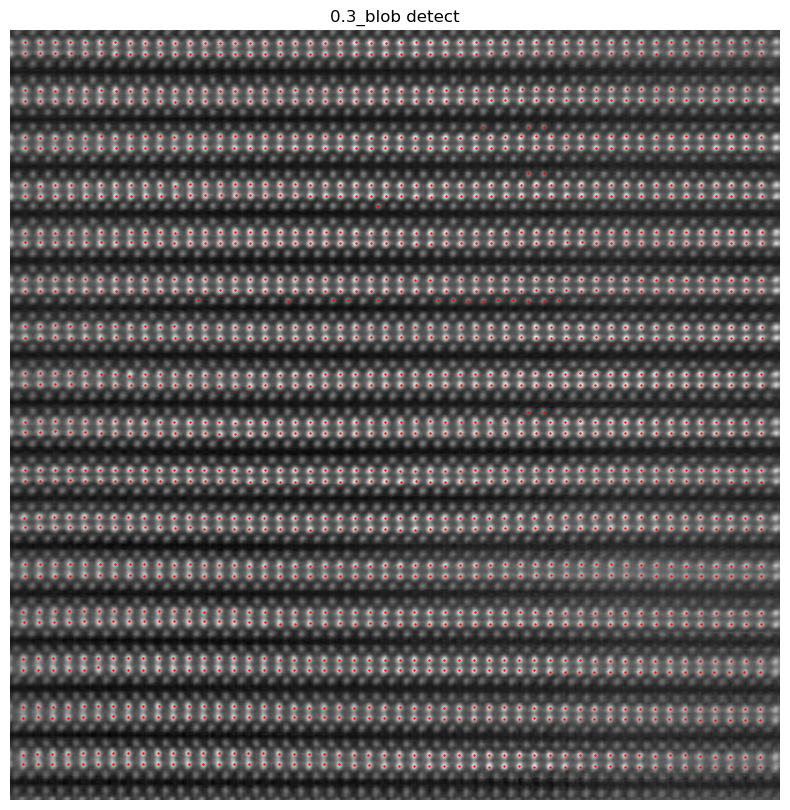

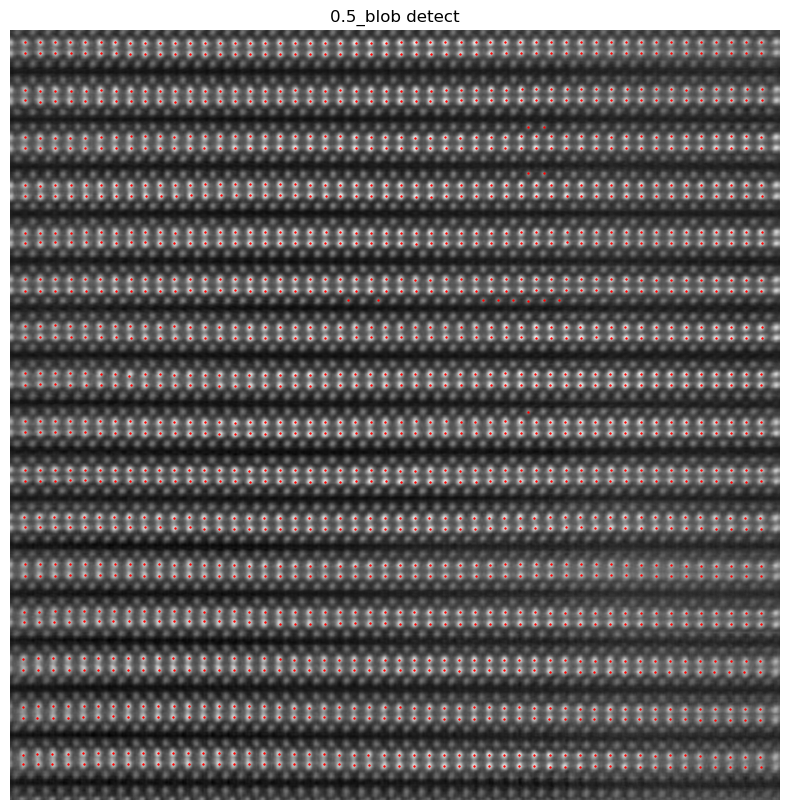

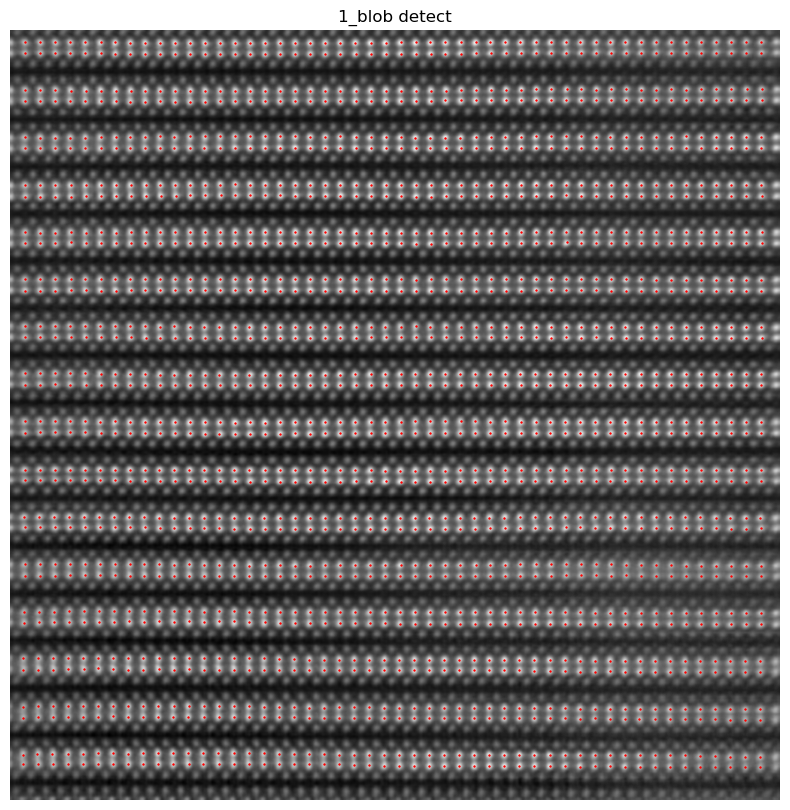

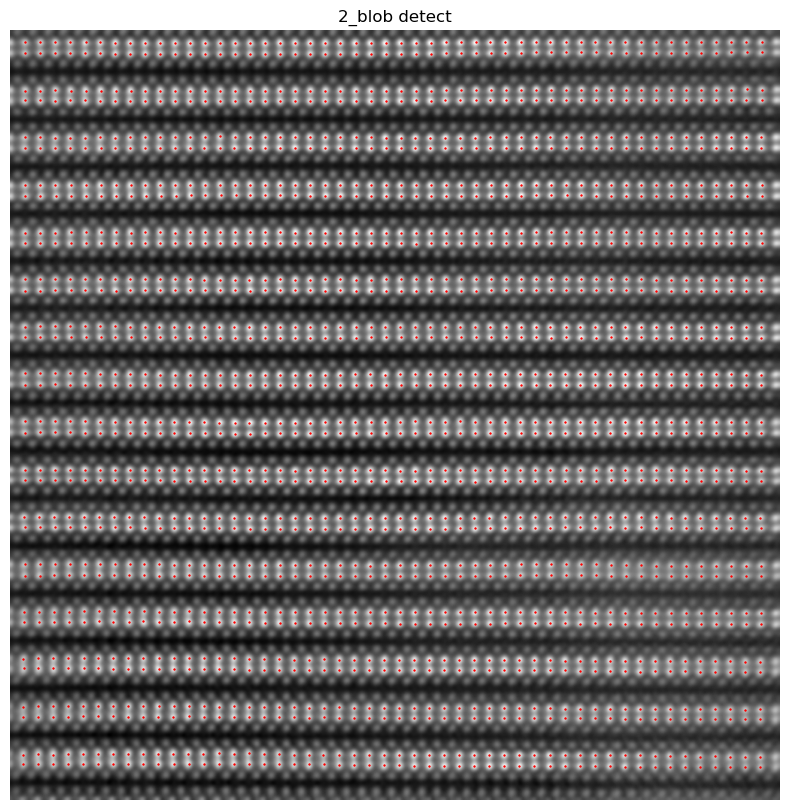

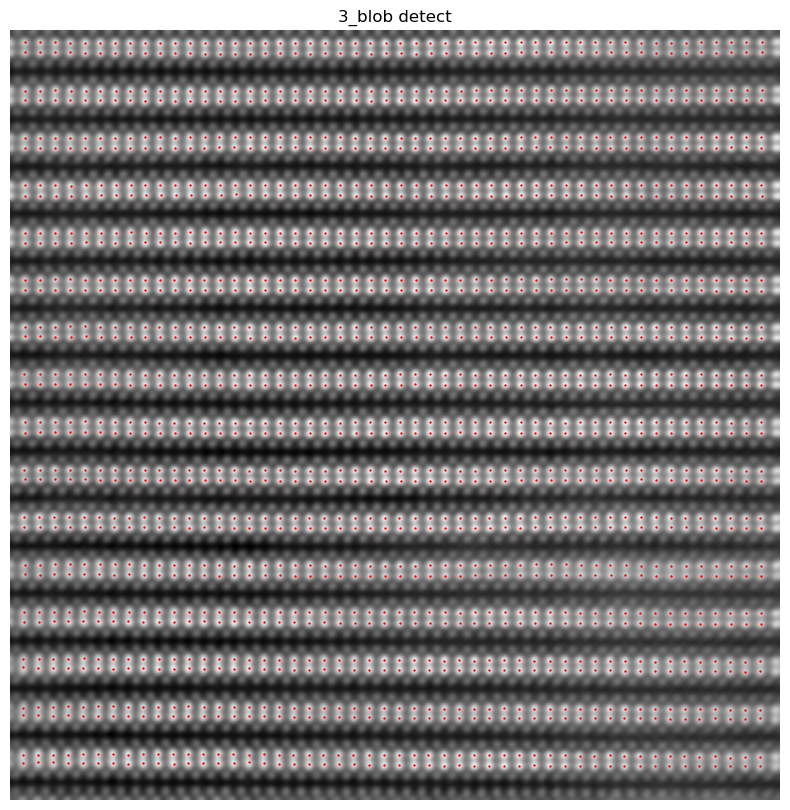

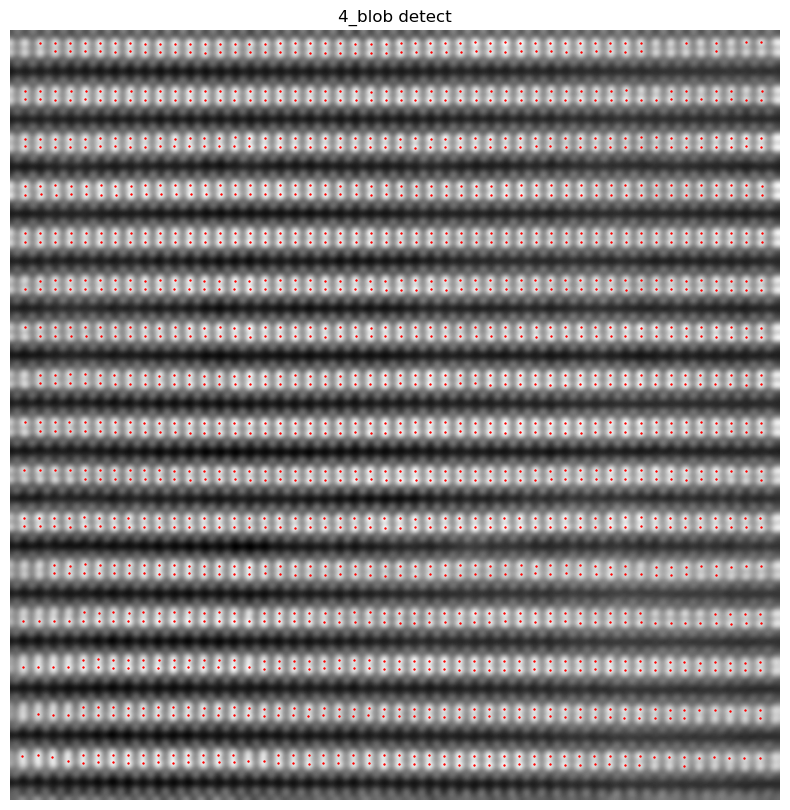

In [5]:
fig_list = []
blob_list = []
threshold = 130
min_distance = 10
for i, sigma in enumerate(sigmas):
    img = gaus_filt_svd_img[i]
    # height, width = img.shape
    # crop_region = (0, 300, width, height) #左上右下
    # img = img[crop_region[1]:crop_region[3], crop_region[0]:crop_region[2]]
    detected_blobs_g_s = blob_detection(img, threshold=threshold, min_distance=min_distance)
    blob_list.append(detected_blobs_g_s)
    i = 0
    while i < len(detected_blobs_g_s):
        if (detected_blobs_g_s[i][0] < 10) or (detected_blobs_g_s[i][1] < 10) or (detected_blobs_g_s[i][0] > (img.shape[0] - 10)) or (detected_blobs_g_s[i][1] > ((img.shape[1] - 10))):
            detected_blobs_g_s.remove(detected_blobs_g_s[i])
        else:
            i += 1
    print("blobs_count_g_s:", len(detected_blobs_g_s))
    save_path = os.path.dirname(image_path) + '/' + str(sigma) + '_blob_detect.png'
    fig = visualize_results(img, detected_blobs_g_s, title=str(sigma) + '_blob detect', save_path=save_path)
    fig_list.append(fig)

<class 'atomap.atom_position.Atom_Position'>
blobs_count: 1600


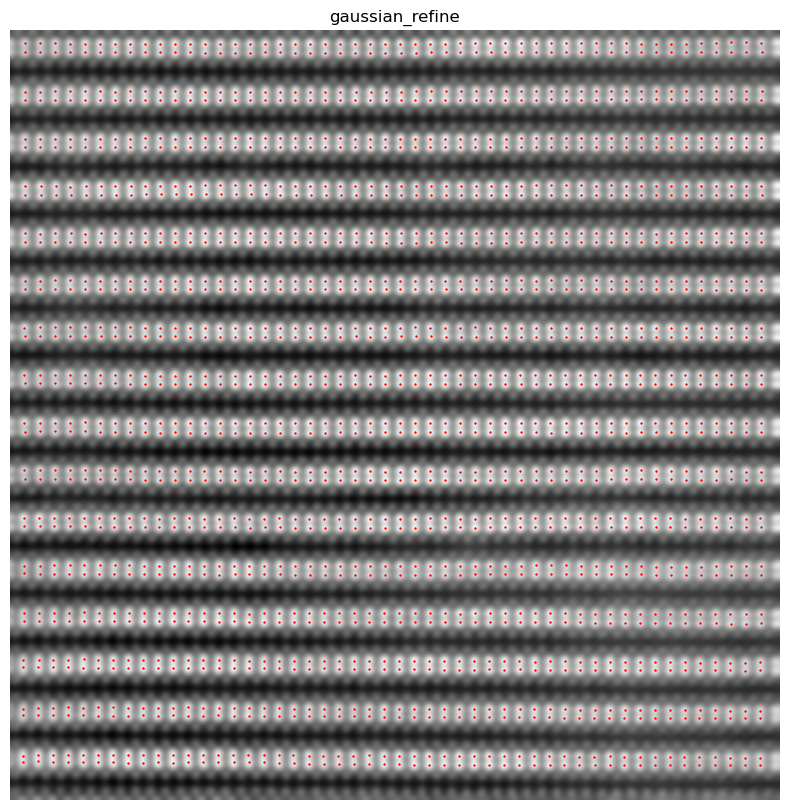

In [6]:
index = 4
sigma = sigmas[index]
input_blobs = blob_list[index]
save_path = os.path.dirname(image_path) + '/' + 'refined.png'
refined_blobs = gaus_refine(image=img, input_blobs=input_blobs, plt_title='gaussian_refine', save_path=save_path)

In [7]:
print('blobs:', refined_blobs)
# 打开文件进行写入
save_path = os.path.dirname(image_path) + '/' + 'blob.txt'
with open(save_path, 'w') as file:
    file.write(f"sigma:{sigma}, threshold:{threshold}, min_distance:{min_distance}\n")
    for blob in refined_blobs:
        # 将每个点转换为字符串并写入文件，每个点占一行
        file.write(f"{blob[0]}, {blob[1]}\n")

print("Blobs have been written to blobs.txt")

blobs: [[16.10149173650106, 958.2958389815485], [15.94481131733383, 978.225081128758], [17.172624681916492, 19.053076856926623], [17.17295937915529, 39.89452950015732], [17.239041544305795, 59.7782543500755], [16.943341040933138, 598.3715915215732], [16.89510089058146, 618.3727106872911], [16.947793662951927, 638.2742058559104], [16.92233620768516, 658.2997950922024], [17.024487264108426, 678.8259674127669], [17.09237772811413, 698.4309317077708], [17.073132361443033, 718.3857203605888], [17.13857192379993, 738.8119130595874], [17.11605385855736, 758.4109272844829], [17.130067153618043, 778.4194435229265], [17.202823541957894, 798.4298890995556], [17.129063834785764, 818.2071005256016], [16.98011094960087, 918.0074980136679], [16.952967699776107, 938.2473022772759], [16.72305125328614, 998.7798996060404], [17.695339832998464, 79.25926817582636], [17.90857379309012, 99.42150830972551], [17.885161386111836, 119.25845116006124], [17.88743569513152, 139.09330165133804], [17.908351467278102

In [8]:
sorted_refined_blobs = sort_blobs_by_y(refined_blobs)
# print(sorted_refined_blobs)
        
group = seperate_into_row(sorted_refined_blobs, 8)

for i, row in enumerate(group):
    group[i] = sorted(row, key=lambda x: x[1])

for i, row in enumerate(group):
    print(f'row {i}: length:{len(row)},  {row}')

Total groups: 32
row 0: length:50,  [[17.172624681916492, 19.053076856926623], [17.17295937915529, 39.89452950015732], [17.239041544305795, 59.7782543500755], [17.695339832998464, 79.25926817582636], [17.90857379309012, 99.42150830972551], [17.885161386111836, 119.25845116006124], [17.88743569513152, 139.09330165133804], [17.908351467278102, 159.1910207235292], [18.027815422193672, 179.02396961675962], [18.107090057975302, 199.09265504203375], [18.011506668468652, 218.89960821695763], [18.10783051833169, 238.88196373459786], [18.043464413083406, 258.9320332906324], [18.04512827387779, 278.9830942844028], [18.12486412788373, 298.92030523025534], [18.058053665795487, 318.95035361008604], [17.95892588895776, 338.5875874157808], [17.783987665396104, 358.4429178572626], [17.828582416789796, 378.4599285938596], [17.762391990360236, 398.4862814833754], [17.875202538944915, 418.6992983959388], [18.01321891152632, 438.76630707588237], [17.982383909438667, 458.41649200715466], [17.92098769070475

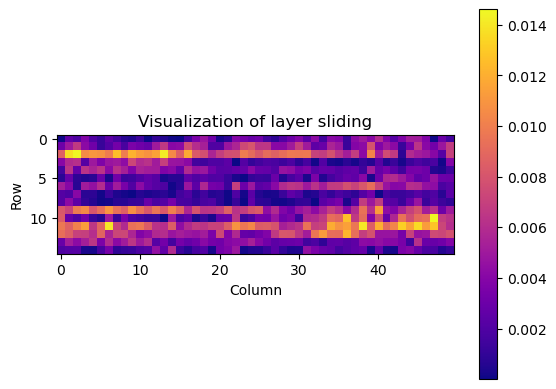

In [9]:
rows = len(group)//2 - 1
cols = len(group[0]) 
array = []
for i in range(rows):
    row = []
    for j in range(cols):
        row.append(0.0)
    array.append(row)
array = np.array(array)

for i in range(0, len(group) - 3, 2):
    index = 0
    for atom1, atom2, atom3, atom4 in zip(group[i], group[i+1], group[i+2], group[i+3]):
        avg1 = (atom1[1] + atom2[1]) / 2
        avg2 = (atom3[1] + atom4[1]) / 2
        array[i//2][index] = abs(avg1 - avg2) * PIXEL_SIZE
        index += 1

reduced_rows = array

# 使用matplotlib的imshow函数来可视化数组
plt.imshow(reduced_rows, cmap='plasma', interpolation='nearest')

# 添加颜色条
plt.colorbar()

# 设置坐标轴
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Visualization of layer sliding')

save_path = os.path.dirname(image_path) + "/" + "output_convert_to_nm.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)